### Michael Hotaling
### Assignment 4: Sentiment Analysis
### 12/19/2020

### Importing basic libraries and the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tweepy as tw
import json
from wordcloud import WordCloud
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from textblob import TextBlob

### Analyzing Tweet Sentiment

In [2]:
with open('twitter_auth.json') as f:
    auth = json.load(f)
    consumer_key = auth['consumer_key']
    consumer_secret = auth['consumer_key_secret']
    access_token = auth['access_key']
    access_token_secret = auth['access_key_secret']

In [3]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tw.API(auth, wait_on_rate_limit=True)

In [19]:
# Define the search term and the date_since date as variables
search_words = "The Mandalorian"
date_since = "2018-01-01"

# We can remove retweets (which will skew our results) and also filter by verified users only if we want
new_search = search_words + " -filter:retweets" #+ " filter:verified"

In [5]:
tweets = tw.Cursor(api.search,
                       q=new_search,
                       lang="en",
                       since=date_since).items(10000)


data = [[tweet.user.screen_name, tweet.text,tweet.favorite_count, tweet.retweet_count] for tweet in tweets]

In [6]:
tweet_text = pd.DataFrame(data=data, 
                    columns=['user','text','likes','retweets'])
tweet_text

,user,text,likes,retweets
0,_hannahhhhh___,Me: I watch The Mandalorian for the plot \n\nT...,0,0
1,geracgalicia73,@marthahigareda The mandalorian 😁😁😁,0,0
2,ITSYABOIEllis,Thanks to the Mandalorian I know when to catch...,0,0
3,CLight89,I get so nervous watching the Mandalorian even...,0,0
4,KevinRigdon1,@ROOTCatZ Seconding Mandalorian and Rogue One....,0,0
...,...,...,...,...
9995,katasstropheee,when can i buy the mandalorian on bluray?? i n...,2,0
9996,Odrinhereboy,@RayGunRichards @sithskywlkers The Ahsoka show...,1,0
9997,Anth553,@aramicvs Pa ver The Mandalorian?,0,0
9998,BB996688,I have not watched the sequels since watching ...,2,0


In [7]:
def remove_at_mentions(arr):
    """Removes @mentions from the text"""
    return re.sub(r'@[A-Za-z0-9_.]+','',arr)

def fix_html_encoding(arr):
    """Removes HTML Encoding from the raw text"""
    return BeautifulSoup(arr, 'lxml').get_text()

def remove_urls(arr):
    """Removes URLS from the text"""
    return re.sub('https?://[A-Za-z0-9./]+','',arr)

def remove_hashtags(arr):
    """Removes hashtags from the text"""
    return re.sub("[^a-zA-Z]", " ", arr)

def remove_emoji(arr):
    """Removes emojies from the text"""
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', arr)


tweet_text["cleaned"] = tweet_text['text'].apply(remove_at_mentions)
tweet_text["cleaned"] = tweet_text['cleaned'].apply(fix_html_encoding)
tweet_text["cleaned"] = tweet_text['cleaned'].apply(remove_urls)
tweet_text["cleaned"] = tweet_text['cleaned'].apply(remove_hashtags)
tweet_text['cleaned'] = tweet_text['cleaned'].apply(remove_emoji)
tweet_text['cleaned'] = tweet_text['cleaned'].str.replace("\n", " ")


# Removing punctuation
#tweet_text["cleaned"] = tweet_text['cleaned'].str.replace('[^\w\s]','')
tweet_text

,user,text,likes,retweets,cleaned
0,_hannahhhhh___,Me: I watch The Mandalorian for the plot \n\nT...,0,0,Me I watch The Mandalorian for the plot The...
1,geracgalicia73,@marthahigareda The mandalorian 😁😁😁,0,0,The mandalorian
2,ITSYABOIEllis,Thanks to the Mandalorian I know when to catch...,0,0,Thanks to the Mandalorian I know when to catch...
3,CLight89,I get so nervous watching the Mandalorian even...,0,0,I get so nervous watching the Mandalorian even...
4,KevinRigdon1,@ROOTCatZ Seconding Mandalorian and Rogue One....,0,0,Seconding Mandalorian and Rogue One Black mir...
...,...,...,...,...,...
9995,katasstropheee,when can i buy the mandalorian on bluray?? i n...,2,0,when can i buy the mandalorian on bluray i n...
9996,Odrinhereboy,@RayGunRichards @sithskywlkers The Ahsoka show...,1,0,The Ahsoka show could ve been something that b...
9997,Anth553,@aramicvs Pa ver The Mandalorian?,0,0,Pa ver The Mandalorian
9998,BB996688,I have not watched the sequels since watching ...,2,0,I have not watched the sequels since watching ...


In [8]:
wordcloud = WordCloud(width=800, height=400).generate(str(tweet_text['cleaned'].values))

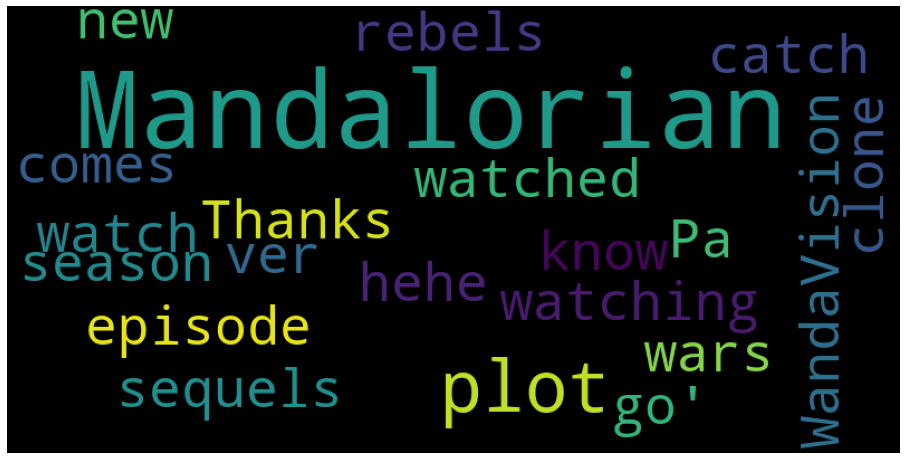

In [9]:
plt.figure(figsize=(16,16))
plt.imshow(wordcloud, interpolation='antialiased')
plt.axis("off")
plt.show()

In [10]:
def vader_sentiment(string):
    """Returns the VADER sentiment for a string"""
    vader = SentimentIntensityAnalyzer()
    return vader.polarity_scores(string)['compound']

def textblob_sentiment(string):
    return TextBlob(string).sentiment.polarity

tweet_text['vader'] = tweet_text['cleaned'].apply(vader_sentiment)
tweet_text['textblob'] = tweet_text['cleaned'].apply(textblob_sentiment)
tweet_text

,user,text,likes,retweets,cleaned,vader,textblob
0,_hannahhhhh___,Me: I watch The Mandalorian for the plot \n\nT...,0,0,Me I watch The Mandalorian for the plot The...,0.0000,0.000000
1,geracgalicia73,@marthahigareda The mandalorian 😁😁😁,0,0,The mandalorian,0.0000,0.000000
2,ITSYABOIEllis,Thanks to the Mandalorian I know when to catch...,0,0,Thanks to the Mandalorian I know when to catch...,0.4404,0.168182
3,CLight89,I get so nervous watching the Mandalorian even...,0,0,I get so nervous watching the Mandalorian even...,0.1298,0.500000
4,KevinRigdon1,@ROOTCatZ Seconding Mandalorian and Rogue One....,0,0,Seconding Mandalorian and Rogue One Black mir...,0.0000,-0.183333
...,...,...,...,...,...,...,...
9995,katasstropheee,when can i buy the mandalorian on bluray?? i n...,2,0,when can i buy the mandalorian on bluray i n...,0.0000,0.000000
9996,Odrinhereboy,@RayGunRichards @sithskywlkers The Ahsoka show...,1,0,The Ahsoka show could ve been something that b...,-0.3818,0.000000
9997,Anth553,@aramicvs Pa ver The Mandalorian?,0,0,Pa ver The Mandalorian,0.0000,0.000000
9998,BB996688,I have not watched the sequels since watching ...,2,0,I have not watched the sequels since watching ...,-0.6597,0.000000


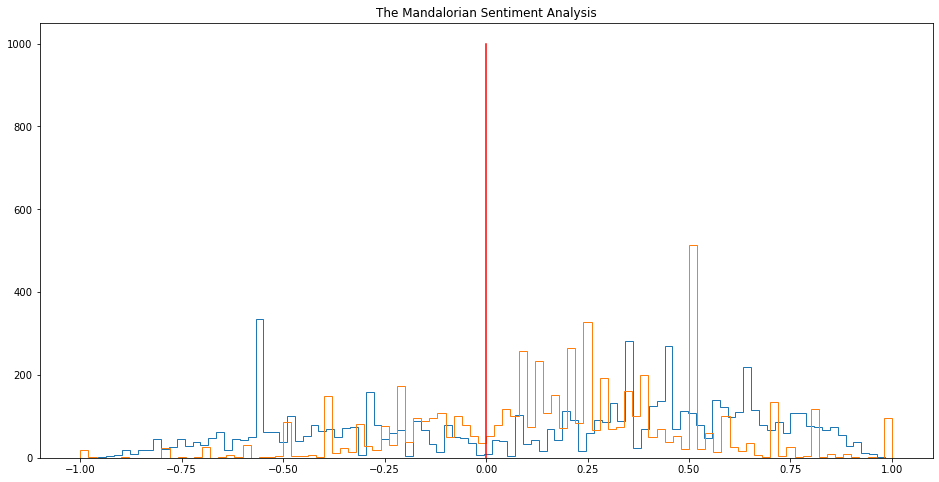

In [46]:
plt.figure(figsize=(16,8))
plt.hist(tweet_text[tweet_text['vader'] != 0]['vader'], bins = 100, histtype="step")
plt.hist(tweet_text[tweet_text['textblob'] != 0]['textblob'], bins = 100, histtype="step")
plt.plot([0, 0], [0, 1000], 'r-')
plt.title(search_words+" Sentiment Analysis")
plt.show()


The Mandalorian: 10973 unique words
-----------------------------------
| Index | Word           |  Count |
-----------------------------------
|     1 | mandalorian    |   7966 |
|     2 | wars           |   1099 |
|     3 | star           |   1068 |
|     4 | season         |    855 |
|     5 | like           |    773 |
|     6 | watching       |    551 |
|     7 | watch          |    500 |
|     8 | one            |    450 |
|     9 | episode        |    414 |
|    10 | disney         |    396 |
|    11 | good           |    378 |
|    12 | game           |    360 |
|    13 | new            |    358 |
|    14 | way            |    348 |
|    15 | series         |    328 |
|    16 | show           |    326 |
|    17 | watched        |    325 |
|    18 | get            |    324 |
|    19 | finished       |    321 |
|    20 | time           |    306 |
|    21 | love           |    296 |
|    22 | would          |    295 |
|    23 | think          |    294 |
|    24 | baby           | 

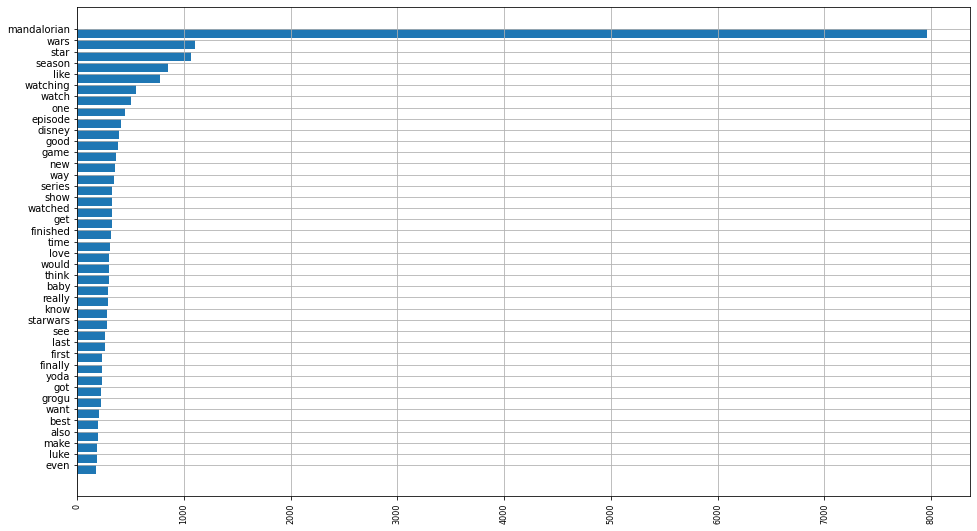

In [44]:
# Imported from my old 510 homework assignment!

import string
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def add_words(words, word_dictionary):
    # We can use an iterative function to add each word to the library
    # If the word doesn't yet exist in the library, we can set the value equal to 1
    for word in words:
        if word != "":
            if word in stop_words:
                pass
            elif word in word_dictionary:
                word_dictionary[word] += 1
            else:
                word_dictionary[word] = 1


def process_line(line, word_dictionary):
    # We will first call strip to remove the leading and trailing spaces in the line
    line = line.strip()
    # Next, we convert all the characters in the line to lower case.
    line = line.lower()
    # This next bit is more complicated. We need to remove special characters from the lines
    # We can use translate to convert the special characters to spaces
    line = line.translate(line.maketrans("", "", string.punctuation))
    # Finally, we can split all the words in each line using spaces as the delimiter
    words = line.split(" ")
    # We can then call the add_words function to add the words to the dictionary
    add_words(words, word_dictionary)


def pretty_print(word_dictionary, title=""):
    print()
    print("{:^35}".format(title + ": " + str(len(word_dictionary)) + " unique words"))
    print("-" * 35)
    print("| {:>5} | {:<15}|{:>7} |".format("Index", "Word", "Count"))
    print("-" * 35)
    index = 1
    for key in sorted(word_dictionary, key=word_dictionary.get, reverse=True):
        if index <= 40:
            print("| {:>5} | {:<15}|{:>7} |".format(index, key, word_dictionary[key]))
        index += 1
    print("-" * 35)


def word_plotter(word_dictionary, title="", show_grids=True):
    # https://stackoverflow.com/questions/37266341/plotting-a-python-dict-in-order-of-key-values/37266356
    # I'd rather use MSPaint than use matplotlib :'(
    # This is so unintuitive
    lists = take(40,sorted(word_dictionary.items(), key=lambda kv: kv[1], reverse=True))
    x, y = zip(*lists)
    plt.figure(figsize=(16,9))
    plt.barh(x, y, align='edge')
    plt.title(title)
    plt.xticks(fontsize=8, rotation=90)
    # I literally can not figure out how to set the y axis ticks to display for every integer.
    # I probably spent 3 hours on this
    # This shouldn't be that hard
    # ggplot2 is literally just:
    # scale_y_continuous(breaks = ...)
    plt.gca().invert_yaxis()
    plt.grid(b=show_grids)
    plt.show()


def main():
    # Added a separate variable assignment to test other txt files
    #file = "gettysburg.txt"
    # file = input("What is the file name?: ")
    #text_file = open(file, 'r')
    word_dictionary = dict()
    for line in tweet_text['cleaned']:
        process_line(line, word_dictionary)
    #text_file.close()
    pretty_print(word_dictionary, title = "The Mandalorian")
    word_plotter(word_dictionary, show_grids=True)


if __name__ == "__main__":
    main()